In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 14.2 MB/s 
     |████████████████████████████████| 498.0 MB 12 kB/s 
     |████████████████████████████████| 1.4 MB 56.6 MB/s 
     |████████████████████████████████| 462 kB 60.6 MB/s 
     |████████████████████████████████| 5.8 MB 60.4 MB/s 


In [2]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 13.7 MB/s 
     |████████████████████████████████| 352 kB 58.0 MB/s 
     |████████████████████████████████| 1.3 MB 56.8 MB/s 
     |████████████████████████████████| 238 kB 81.1 MB/s 
     |████████████████████████████████| 1.1 MB 73.1 MB/s 
     |████████████████████████████████| 118 kB 76.3 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 


In [3]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import string
import numpy as np
import nltk
import re
from official.nlp import optimization 

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
from shutil import copyfile
import matplotlib.pyplot as plt


/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
tf.get_logger().setLevel('ERROR')

In [5]:
!wget --no-check-certificate \
    "https://github.com/jgolbeck/fakenews/blob/master/FakeNewsData.zip?raw=true" \
    -O "/tmp/FakeNewsData.zip"

local_zip = '/tmp/FakeNewsData.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-12-20 07:33:53--  https://github.com/jgolbeck/fakenews/blob/master/FakeNewsData.zip?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/jgolbeck/fakenews/raw/master/FakeNewsData.zip [following]
--2022-12-20 07:33:54--  https://github.com/jgolbeck/fakenews/raw/master/FakeNewsData.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jgolbeck/fakenews/master/FakeNewsData.zip [following]
--2022-12-20 07:33:54--  https://raw.githubusercontent.com/jgolbeck/fakenews/master/FakeNewsData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting resp

Now the images are stored within the `/tmp/FakeNewsData` directory. There is a subdirectory for each class, so one for fake and one for satire.

In [6]:
source_path = '/tmp/FakeNewsData/StoryText 2'

source_path_fake = os.path.join(source_path, 'Fake/finalFake')
source_path_satire = os.path.join(source_path, 'Satire/finalSatire')


# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_fake))} texts of fake.")
print(f"There are {len(os.listdir(source_path_satire))} texts of satire.")

There are 284 texts of fake.
There are 204 texts of satire.


In [7]:
# Defining root directory
root_dir = '/tmp/fkae-or-satire'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# Create_train_test_dirs
def create_train_test_dirs(root_path):

  train_dir = os.path.join(root_path, 'training')
  test_dir = os.path.join(root_path, 'testing')
  os.makedirs(train_dir)
  os.makedirs(test_dir)

  # Directory with training cat/dog pictures
  train_fake_dir = os.path.join(train_dir, 'fake')
  train_satire_dir = os.path.join(train_dir, 'satire')
  os.makedirs(train_fake_dir)
  os.makedirs(train_satire_dir)

  # Directory with test cat/dog pictures
  test_fake_dir = os.path.join(test_dir, 'fake')
  test_satire_dir = os.path.join(test_dir, 'satire')
  os.makedirs(test_fake_dir)
  os.makedirs(test_satire_dir)

  pass
  
try:
  create_train_test_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [8]:
# Testing create_train_test_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/fkae-or-satire/training
/tmp/fkae-or-satire/testing
/tmp/fkae-or-satire/training/fake
/tmp/fkae-or-satire/training/satire
/tmp/fkae-or-satire/testing/fake
/tmp/fkae-or-satire/testing/satire


Random split and clean the text before copy 

In [9]:
def remove_urls(text):
    # Use a regular expression to match URLs
    url_pattern = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
    return re.sub(url_pattern, '', text)

clean_text(text) - remove urls, remove stopwords

In [ ]:
# Define a function to handle text data cleaning
def clean_text(text):
    url_pattern = r'(http|https):\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
    text_filtered = re.sub(url_pattern, '', text)

    text_filtered = "".join([word.lower() for word in text_filtered if word not in string.punctuation])
    tokens = re.split('\W+', text_filtered)
    text_filtered = (" ").join([word for word in tokens if word not in stopwords])

    # Use a regular expression to match URLs
    return text_filtered


In [10]:
from sklearn.model_selection import train_test_split

#  Split_data
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  if(SPLIT_SIZE % 1 == 0):
    SPLIT_SIZE = 0.25
  news = os.listdir(SOURCE)
  news_test , news_train =  train_test_split(news, test_size = SPLIT_SIZE, shuffle  = True) 

  for text in news_train:
    if(os.path.getsize(os.path.join(SOURCE,text)) == 0):
      print(text," is zero length, so ignoring.")
    else:
        with open(os.path.join(SOURCE, text), 'r', encoding='ascii',errors='ignore') as f:
            contents = f.read()
            cleaned_text = clean_text(contents)
        with open(os.path.join(TRAINING,text), 'w') as f:
            # Write the cleaned text to the file
            f.write(cleaned_text)

  for text in news_test:
    if(os.path.getsize(os.path.join(SOURCE,text)) == 0):
      print(text, " is zero length, so ignoring.")
    else:
        with open(os.path.join(SOURCE, text), 'r', encoding='ascii',errors='ignore') as f:
            contents = f.read()
            cleaned_text = clean_text(contents)
        with open(os.path.join(TESTING,text), 'w') as f:
            # Write the cleaned text to the file
            f.write(cleaned_text)

  pass



In [12]:
# Test split_data function

# Define paths
FAKE_SOURCE_DIR = os.path.join(source_path, 'Fake/finalFake')
SATIRE_SOURCE_DIR = os.path.join(source_path, 'Satire/finalSatire')

TRAINING_DIR = "/tmp/fkae-or-satire/training/"
TESTING_DIR = "/tmp/fkae-or-satire/testing/"

TRAINING_FAKE_DIR = os.path.join(TRAINING_DIR, "fake/")
TESTING_FAKE_DIR = os.path.join(TESTING_DIR, "fake/")

TRAINING_SATIRE_DIR = os.path.join(TRAINING_DIR, "satire/")
TESTING_SATIRE_DIR = os.path.join(TESTING_DIR, "satire/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_FAKE_DIR)) > 0:
  for file in os.scandir(TRAINING_FAKE_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_SATIRE_DIR)) > 0:
  for file in os.scandir(TRAINING_SATIRE_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_FAKE_DIR)) > 0:
  for file in os.scandir(TESTING_FAKE_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_SATIRE_DIR)) > 0:
  for file in os.scandir(TESTING_SATIRE_DIR):
    os.remove(file.path)

# Define proportion of texts used for training
split_size = .7

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(FAKE_SOURCE_DIR, TRAINING_FAKE_DIR, TESTING_FAKE_DIR, split_size)
split_data(SATIRE_SOURCE_DIR, TRAINING_SATIRE_DIR, TESTING_SATIRE_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_FAKE_DIR))} texts of fake for training")
print(f"There are {len(os.listdir(TRAINING_SATIRE_DIR))} texts of satire for training")
print(f"There are {len(os.listdir(TESTING_FAKE_DIR))} texts of cats fake testing")
print(f"There are {len(os.listdir(TESTING_SATIRE_DIR))} texts of satire for testing")



There are 199 texts of fake for training
There are 143 texts of satire for training
There are 85 texts of cats fake testing
There are 61 texts of satire for testing


In [13]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    TRAINING_DIR,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    TRAINING_DIR,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    TESTING_DIR,
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 341 files belonging to 2 classes.
Using 273 files for training.
Found 341 files belonging to 2 classes.
Using 68 files for validation.
Found 145 files belonging to 2 classes.


## **Some news examples**

In [14]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(4):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'npr 25 million votes clinton completely fake lost popular vote study published npr reveals 25 million hillary clinton votes completely fraudulent meaning democratic candidate actually lost popular vote huge margin study pew center claiming 800000 noncitizens voted hillary clinton failed take account dead fraudulent voters totalled 25 million registered voters according reports illegal aliens combined dead voters multiple state voters explains hillary appeared popular vote trump years presidential race report pew center states finds 18 million dead people currently registered vote 24 million registrations either invalid inaccurate npr reported 2012 ironic given npr heavily controlled democrats many dead registered voters somehow keep voting democrat beyond grave recently philadelphia penn colorado also worth noting us population increased since 2012 meaning theres likely dead invalid voters pew study found almost 3 million people registered vote one state npr added thats new r

In [15]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [16]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.9.*"

     |████████████████████████████████| 4.6 MB 11.0 MB/s 
     |████████████████████████████████| 511.8 MB 27 kB/s 
     |████████████████████████████████| 438 kB 72.0 MB/s 
     |████████████████████████████████| 5.8 MB 64.5 MB/s 
     |████████████████████████████████| 1.6 MB 57.8 MB/s 


In [17]:
import tensorflow_text

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [18]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(128)(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(16)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [19]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [20]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(['text_test']))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.26133057]], shape=(1, 1), dtype=float32)


In [21]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)



In [22]:
history = classifier_model.fit(x=train_ds,
                              epochs=15,
                              # batch_size=16,
                              validation_data=val_ds)

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/18 [===========================>..] - ETA: 0s - loss: 0.8664 - binary_accuracy: 0.5735WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f0818fb6ca0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
18/18 [==============================] - 13s 294ms/step - loss: 0.8647 - bi

In [23]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [24]:

history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

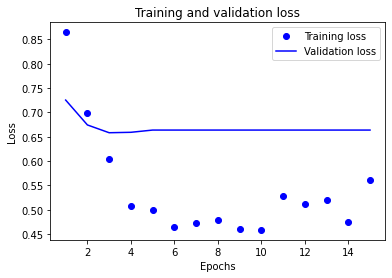

In [25]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

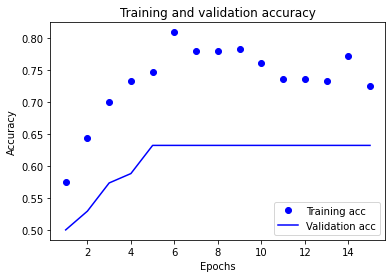

In [26]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Save model

In [27]:
dataset_name = 'FakeNewsData'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=True)

Cause: could not parse the source code of <function _trace_resource_initializers.<locals>._wrap_obj_initializer.<locals>.<lambda> at 0x7f081989c9d0>: no matching AST found among candidates:
# coding=utf-8
(lambda : _wrap_initializer(obj))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [28]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [29]:
print(saved_model_path)

./FakeNewsData_bert


In [31]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'spicer trump led brexit successfully upperclass eloquent english skills wednesdays press briefing white house press secretary sean spicer gave strange response european commission president jeanclaude junker criticized president donald trumps comprehension world affairs last week junker warned countries may leave european union trumps administration applauded britains departure eu think president well steeped world affairs especially europe nato issues spicer insisted leader effort call brexit know asked comment whether connection president trumps position brexit fact majority britains citizens voted leaving eu spicer argued british smitten billionaire businessmanturnedpresidents language skills decided hear know president trump citizens uk havent really gotten right foot speak think remember one point even petition floating around ban donald trump entering great britain spicer reminded members press however ask british today felt president believe would encounter different responses continued personal opinion belief british people became smitten fact donald trump one point spoke upperclass eloquent english realized okay person make matters even obvious president trump scottish heritage mothers side theres also im well aware fact english scottish dont always see eye eye despite union would seem managed find common ground comes president donald trump asked elaborate trumps rumored eloquent language skills press secretary argued even though trumps language muchdisputed point campaign donald trump known extremely hard worker selfmade billionaire also said thats comes surprise able improve language point became favorite citizens country language first originated put perspective talking england know pretty much nothing left show complicated language rules extremely broad dictionary end day im going say english voted leave eu donald trump said would good idea however would like believe deep listened really heard saying precisely speaking nice language compare situation theyre debating whether theyre going let country think thats equivalent climbing mount everest matter minutes huge undertaking way fact mount everests summit cold british towards americans makes sweeter would imagine spicer concluded',

]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)

Results from the saved model:
input: spicer trump led brexit successfully upperclass eloquent english skills wednesdays press briefing white house press secretary sean spicer gave strange response european commission president jeanclaude junker criticized president donald trumps comprehension world affairs last week junker warned countries may leave european union trumps administration applauded britains departure eu think president well steeped world affairs especially europe nato issues spicer insisted leader effort call brexit know asked comment whether connection president trumps position brexit fact majority britains citizens voted leaving eu spicer argued british smitten billionaire businessmanturnedpresidents language skills decided hear know president trump citizens uk havent really gotten right foot speak think remember one point even petition floating around ban donald trump entering great britain spicer reminded members press however ask british today felt president believe 

In [32]:
print(round(float(reloaded_results)))

1
